In [35]:
# !pip install wandb -qU

In [36]:
# Log in to your W&B account
# import wandb
# wandb.login()

In [37]:
class_names = ["Whole", "Half", "Quarter", "Eight", "Sixteenth"]

In [38]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import numpy as np

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
from torch import nn
class MyModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=hidden_units*2),
            nn.Linear(in_features=hidden_units*2, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [41]:
model = MyModel(input_shape=1 * 64 * 64,
                              hidden_units=32,
                              output_shape=len(class_names)).to(device)
model.to(device)

MyModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [42]:
import numpy as np
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/Colab Notebooks/CSV_Data/data1.csv"

images = np.loadtxt(file_path, dtype=int, delimiter=',', usecols=range(1, 4097), skiprows=1)
labels = np.loadtxt(file_path, dtype=str, delimiter=",", usecols=0, skiprows=1)

/tmp/ipython-input-613835000.py:7: UserWarning: Input line 2 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  labels = np.loadtxt(file_path, dtype=str, delimiter=",", usecols=0, skiprows=1)


In [43]:
classes = np.array([])
for c in labels:
  classes = np.append(classes, (np.int32(class_names.index(c))))

In [44]:
images = images.reshape(5000, 1, 64, 64)

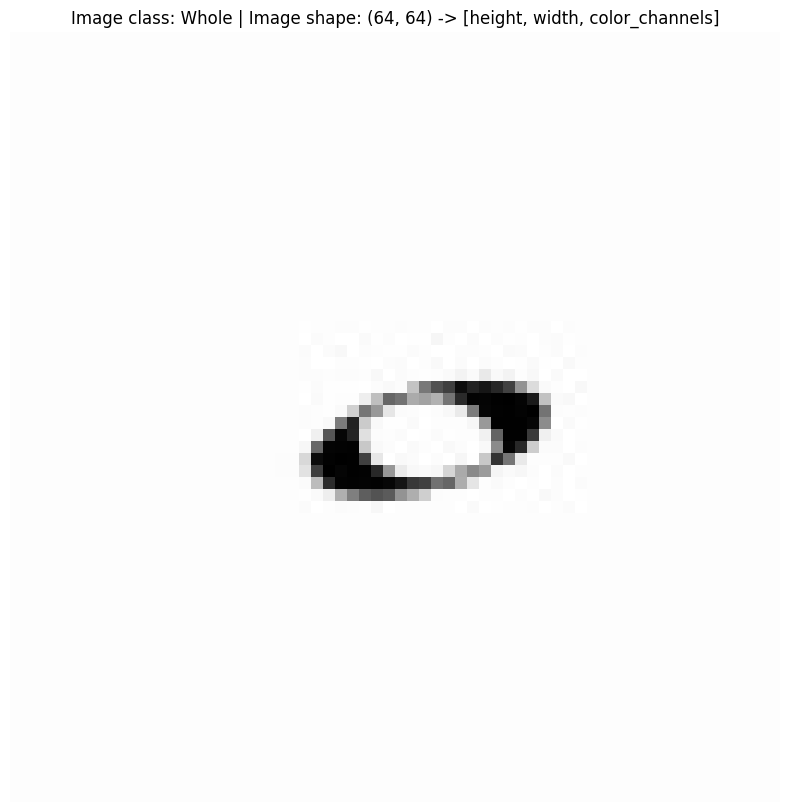

In [45]:
import random as r
rand = r.randint(0, 4096)
img_as_array = images[rand]
img_as_array = img_as_array.reshape(64, -1)

img_as_array
# Plot the image with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(img_as_array, cmap="gray")
plt.title(f"Image class: {labels[rand]} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [46]:
images = torch.from_numpy(images).to(torch.float32)
classes = torch.from_numpy(classes).type(torch.LongTensor)

In [47]:
train_images, test_images, train_labels, test_labels = train_test_split(images,
                                                                        classes,
                                                                        test_size=0.2)

In [48]:
len(train_images), len(test_images), len(train_labels), len(test_labels)

(4000, 1000, 4000, 1000)

In [49]:
# Download Helper Function (if it doesn't already exist)
import os
import requests
from pathlib import PurePath
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [50]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [51]:
train_images.shape

torch.Size([4000, 1, 64, 64])

In [52]:
train_labels.shape

torch.Size([4000])

In [53]:
from torch.utils.data import Dataset

class DatasetCustom(Dataset):
  def __init__(self, train, classes, transform=None):
    self.train = train
    self.transform = transform
    self.classes = classes

  def load_image(self, index: int):
    return self.train[index]

  def __len__(self):
    return len(self.train)

  def __getitem__(self, index: int):
    img = self.load_image(index)

    if self.transform:
      return (self.transform(img), self.classes[index])
    else:
      return img, self.classes[index]

In [54]:
from torchvision import transforms
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [55]:
train_data_custom = DatasetCustom(train=train_images,
                                  classes=train_labels,
                                  transform=data_transform)
test_data_custom = DatasetCustom(train=test_images,
                                 classes=test_labels,
                                 transform=data_transform)

In [56]:
len(train_data_custom), len(test_data_custom)

(4000, 1000)

In [57]:
print(len(test_images))

1000


In [58]:
# custom dataloader
# Since our images are already numpy arrays (converted to tensors), we don't need a dataset function
from torch.utils.data import DataLoader

# We do, however, need to transform our current image data into a 2D array/tensor instead of a 1D array/tensor
# and combine it with the labels

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=32,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

In [59]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 1, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [60]:
import random
from typing import List
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)[:, :, 0]

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        print(targ_image)

        plt.imshow(targ_image_adjust, cmap="gray")
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]])
tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]])
tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.

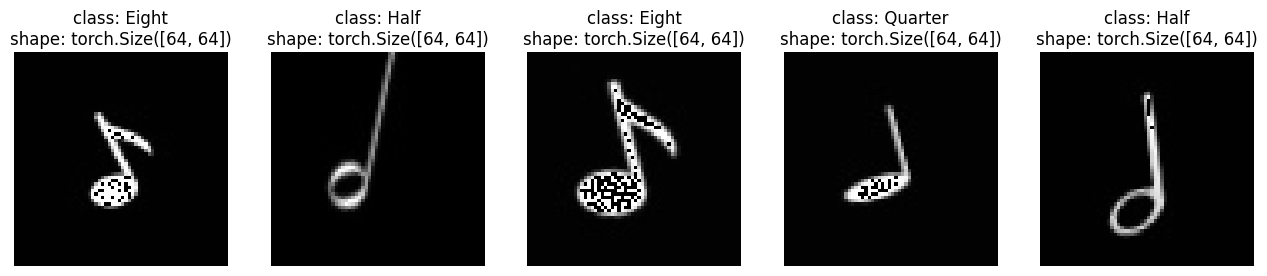

In [61]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [62]:
# class Identity(nn.Module):
#   def __init__(self):
#     super(Identity, self).__init__()

#   def forward(self, x):
#     return x

# model = torchvision.models.vgg16(pretrained=True)
# model.avgpool = Identity()
# model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# model.classifier = nn.Linear(in_features=2048, out_features=5)
# model.to(device)
# print(model)

In [63]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_custom))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 1, 64, 64])

Output logits:
tensor([[ 0.0817,  0.0082, -0.1789, -0.0554,  0.0598]], device='cuda:0')

Output prediction probabilities:
tensor([[0.2198, 0.2042, 0.1694, 0.1916, 0.2150]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
3


In [64]:
# from tqdm.auto import tqdm

total_runs = 1
for run in range(total_runs):
  # Start a new run to track this script
  # wandb.init(
  #     # Set the project where this run will be logged
  #     project="basic-intro",
  #     # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
  #     name=f"experiment_{run}",
  #     # Track hyperparameters and run metadata
  #     config={
  #     "learning_rate": 0.1,
  #     "architecture": "Flattened Linear",
  #     "dataset": "5 Musical Notes",
  #     "epochs": 10,
  #     })
  epochs = 15
  for epoch in (range(epochs)):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader_custom):
      # Training mode
      model.train()

      # Send to device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      logits = model(X)
      pred = torch.softmax(logits, dim=1).argmax(dim=1)

      # 2. Calculate the loss/accuracy
      loss = loss_fn(logits, y)
      train_loss += loss
      train_acc += accuracy_fn(y_true=y,
                              y_pred=pred)

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Step the optimizer
      optimizer.step()

      # Calculate loss and accuracy per epoch and print out what's happening
    train_acc /= len(train_dataloader_custom)
    train_loss /= len(train_dataloader_custom)

    metrics = {"train/train_loss": train_loss,
                "train/example_acc": train_acc}
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


    model.eval() # put model in eval mode
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
      for batch, (X, y) in enumerate(test_dataloader_custom):

        # Send to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_logits = model(X)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calculate loss and accuracy
        test_loss += loss_fn(test_logits, y)
        test_acc += accuracy_fn(y_true=y,
            y_pred=test_preds # Go from logits -> pred labels
          )

      # # Adjust metrics and print out
      # test_loss /= len(test_dataloader_custom)
      # test_acc /= len(test_dataloader_custom)
      # log train and validation metrics to wandb
      # val_metrics = {"test/test_loss": test_loss,
      #                 "test/test_accuracy": test_acc}
      # wandb.log({**metrics, **val_metrics})

      print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
  # Mark the run as finished
  # wandb.finish()

Train loss: 1.03454 | Train accuracy: 55.98%
Test loss: 686.56543 | Test accuracy: 66200.00%

Train loss: 0.57587 | Train accuracy: 74.03%
Test loss: 557.05914 | Test accuracy: 74600.00%

Train loss: 0.48856 | Train accuracy: 78.10%
Test loss: 502.35220 | Test accuracy: 77500.00%

Train loss: 0.42368 | Train accuracy: 81.33%
Test loss: 476.98343 | Test accuracy: 77800.00%

Train loss: 0.36217 | Train accuracy: 83.72%
Test loss: 480.81992 | Test accuracy: 80800.00%

Train loss: 0.30497 | Train accuracy: 86.20%
Test loss: 589.58368 | Test accuracy: 76400.00%

Train loss: 0.35657 | Train accuracy: 85.17%
Test loss: 550.22217 | Test accuracy: 76900.00%

Train loss: 0.24370 | Train accuracy: 89.30%
Test loss: 675.89532 | Test accuracy: 76200.00%

Train loss: 0.25757 | Train accuracy: 88.25%
Test loss: 570.74023 | Test accuracy: 77600.00%

Train loss: 0.24452 | Train accuracy: 89.42%
Test loss: 699.05444 | Test accuracy: 77800.00%

Train loss: 0.23917 | Train accuracy: 89.65%
Test loss: 588.

In [65]:
prediction_transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [66]:
test_images.shape

torch.Size([1000, 1, 64, 64])

In [67]:
# predictions
pred_probs = []
model.eval()
with torch.inference_mode():
  for i in test_images:
    pred_images = prediction_transformation(i).to(device)
    logits = model(pred_images)
    pred = torch.softmax(logits, dim=1).argmax(dim=1)
    pred_probs.append(pred)

pred = torch.stack(pred_probs)
pass

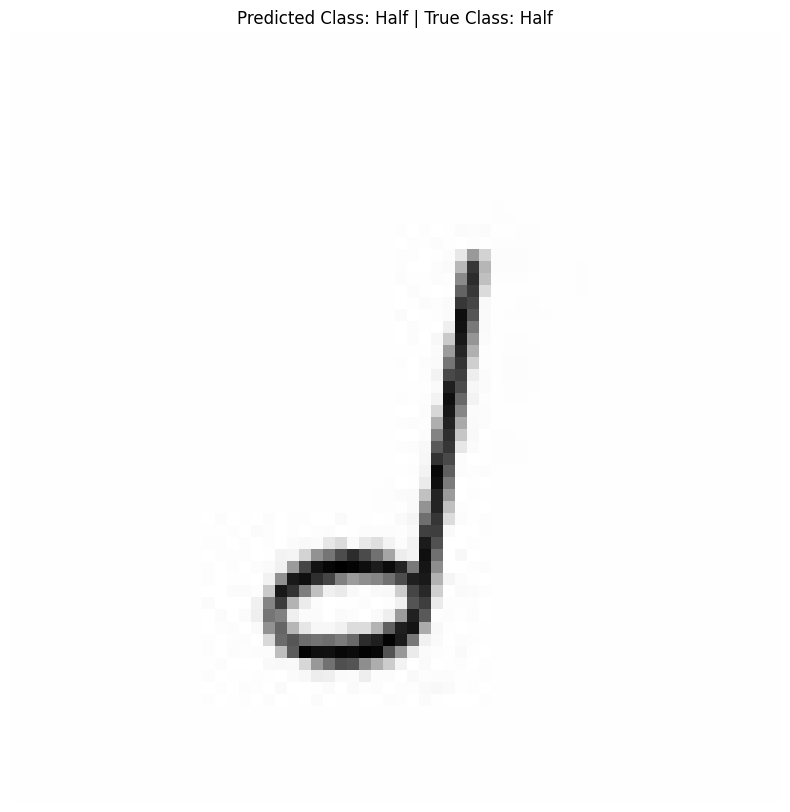

In [68]:
rand = r.randint(0, len(test_labels))
img_label = test_labels[rand].numpy()
img_as_array = test_images[rand].to("cpu").numpy()
img_as_array = img_as_array.reshape(64, -1)

img_as_array
# Plot the image with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(img_as_array, cmap="gray")
plt.title(f"Predicted Class: {class_names[pred[rand]]} | True Class: {class_names[img_label]}")
plt.axis(False);